<a href="https://colab.research.google.com/github/ebamberg/research-projects-ml/blob/main/Image_Generation/examples_diffusers_first_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Showcase using pretrained diffusers Models



We need to install required libraries from Huggingface.

"diffuser" - the diffuser library

"transformers"

In [1]:
# install the necessary libraries in Colab
!pip install --upgrade  diffusers accelerate transformers  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.5 MB/s eta 0:00:00


## use pretrained and preconfigured pipelines

we can load a pretrained Diffuser pipeline.

In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)
# move the pipeline to the GPU
pipeline.to("cuda")
print (pipeline)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}




### replace the scheduler
We can replace the default scheduler that is stored with the pipeline with another one ....

In [ ]:
from diffusers import EulerDiscreteScheduler
pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

  0%|          | 0/50 [00:00<?, ?it/s]

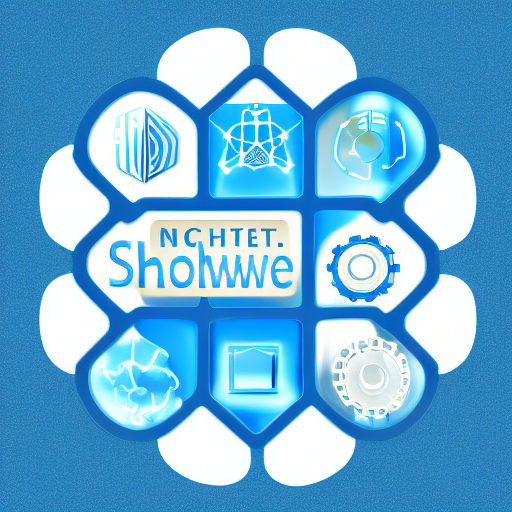

In [ ]:
image = pipeline("showcase machine learning, network, blue, logo, icon").images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

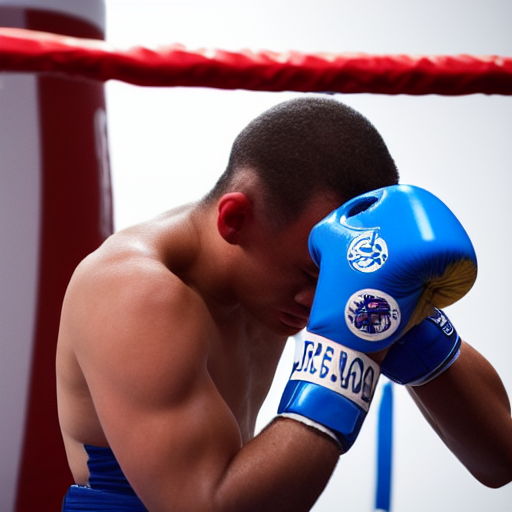

In [ ]:
image = pipeline("An image of a boxer looking to right ring").images[0]
image


## Work with Diffuser Model - Build your own pipeline
now we try to work with a diffuser-model directly

### PIL Images and tensor Image

tensor images have the format channel,width, height
a batch of tensor images has the format batch,channel,width,height
PIL images are width, height, channels

so we have to convert our tensor image to PIL image structure before displaying.

We define 2 functions to display images and another function to create a noise that only contains noise


In [2]:
import PIL.Image
import numpy as np


def display_sample(sample):
    image_processed = sample.cpu().permute(0, 2, 3, 1) # resort dimension, first the pixels and the channels last
    image_processed = (image_processed + 1.0) * 127.5  # make bytes between -127 and 127
    image_processed = image_processed.numpy().astype(np.uint8) #convert to numpy cause this is what PIL.IMage wants

    image_pil = PIL.Image.fromarray(image_processed[0]) # create an image. first dimension is the batch so we ignore this
    display(image_pil)

def createNoiseImage(width,height,channels):
  torch.manual_seed(0)
  return torch.randn(1, channels, width, height)



To go from one noise sample to the next less noise sample we can call the scheduler step function. The function takes as parameter the model that we want to use for denoising a image and as sample the noisy image that we want to denoise.

To get from one image to next image we also have to pass in which scheduler step we are using for the conversion.
Why is this necessary ?
The nature of Diffusers is to learn the denoising process in many steps during training , meaning the we start  with a slightly noised image and during training steps add more and more noise to it.
To control this process we use a "Scheduler". Linear adding noise would cause bad training results cause the image getting to early in a state where it just contains noise information.
Scheduler usually add noise non-linear to the image.



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

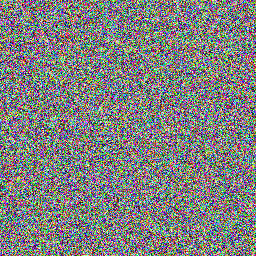

In [3]:
from diffusers import UNet2DModel
import torch
from diffusers import DDPMScheduler


repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id, use_safetensors=True)
scheduler = DDPMScheduler.from_pretrained(repo_id)

# model.config

# lets create a noise image . 1 is the batchsize, the nextdimensions are nr of channels and width*height for the pixels
torch.manual_seed(0)

noisy_sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size)
# noisy_sample.shape

# move all the stuff to the GPU for higher performance
model=model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample
#noisy_residual.shape
less_noisy_sample = scheduler.step(model_output=noisy_residual, timestep=2, sample=noisy_sample).prev_sample
display_sample(less_noisy_sample)

Knowing that, we can implement a loop to get step by step from completly noise to a nice cat image.
we are just calling the scheduler in a loop and passing the previous denoised image again and again to the scheduler incrementing the timestep we want to use. We can watch how the diffuser reduce step by step more noise and create a beautiful cute cat image.


In [6]:
import tqdm
from diffusers import UNet2DModel
import torch
from diffusers import DDPMScheduler


repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id, use_safetensors=False)
scheduler = DDPMScheduler.from_pretrained(repo_id)

noise = createNoiseImage(model.config.sample_size, model.config.sample_size,model.config.in_channels)
# move all the stuff to the GPU for higher performance
noise=noise.to("cuda")
model.to("cuda")

sample=noise

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  with torch.no_grad():
      noisy_residual = model(sample, t).sample
  sample = scheduler.step(noisy_residual, t, sample).prev_sample
  if (i + 1) % 50 == 0:
        print (f"iteration {i} timestep {t}")
        display_sample(sample)

An error occurred while trying to fetch google/ddpm-church-256: google/ddpm-church-256 does not appear to have a file named diffusion_pytorch_model.safetensors.


OSError: google/ddpm-church-256 does not appear to have a file named diffusion_pytorch_model.safetensors.

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

 10%|▉         | 99/1000 [00:12<01:54,  7.86it/s]

'Image at step 100'

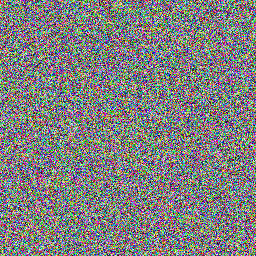

 20%|█▉        | 199/1000 [00:25<01:47,  7.48it/s]

'Image at step 200'

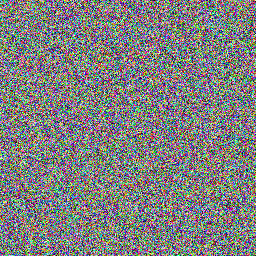

 30%|██▉       | 299/1000 [00:38<01:38,  7.14it/s]

'Image at step 300'

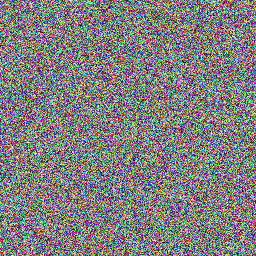

 40%|███▉      | 399/1000 [00:51<01:15,  7.93it/s]

'Image at step 400'

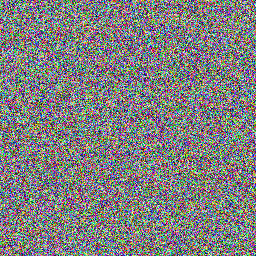

 50%|████▉     | 499/1000 [01:04<01:02,  8.01it/s]

'Image at step 500'

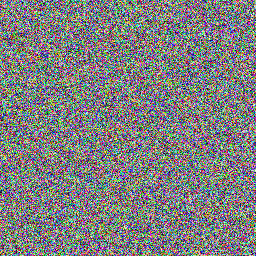

 60%|█████▉    | 599/1000 [01:17<00:50,  7.92it/s]

'Image at step 600'

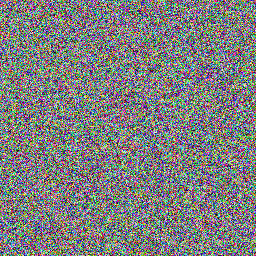

 70%|██████▉   | 699/1000 [01:29<00:37,  8.07it/s]

'Image at step 700'

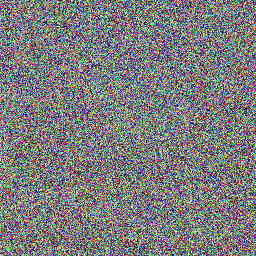

 80%|███████▉  | 799/1000 [01:42<00:25,  7.73it/s]

'Image at step 800'

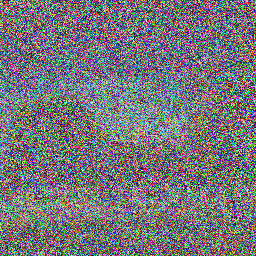

 90%|████████▉ | 899/1000 [01:54<00:12,  7.90it/s]

'Image at step 900'

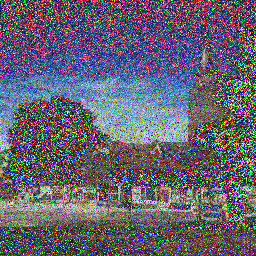

100%|█████████▉| 999/1000 [02:07<00:00,  7.90it/s]

'Image at step 1000'

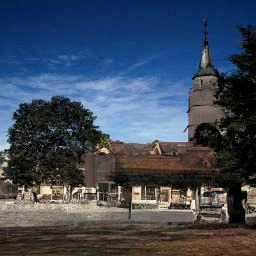

100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]


In [5]:
import tqdm

import PIL.Image
import numpy as np
from diffusers import DDPMScheduler

from diffusers import UNet2DModel
import torch

repo_id = "google/ddpm-church-256"

model = UNet2DModel.from_pretrained(repo_id, use_safetensors=False)

scheduler = DDPMScheduler.from_pretrained(repo_id)

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)


# torch.manual_seed(0)

noisy_sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size)
noisy_sample.shape

model=model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

sample = noisy_sample
# scheduler.set_timesteps(200)

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
       residual = model(sample, t).sample
       # 2. compute less noisy image and set x_t -> x_t-1
       denoised_sample = scheduler.step(residual, t, sample).prev_sample
    sample = denoised_sample

    # 3. optionally look at image
    if (i + 1) % 100 == 0:
        display_sample(sample, i + 1)

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-church-256/snapshots/5a1118b5a35e744d59a4215a8c72a4d7619b9e04: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-church-256/snapshots/5a1118b5a35e744d59a4215a8c72a4d7619b9e04.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "google/ddpm-church-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}



  0%|          | 0/1000 [00:00<?, ?it/s]

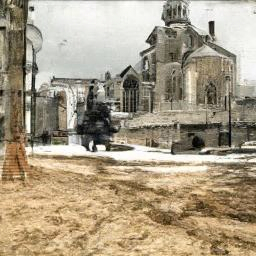

In [ ]:
# !pip install diffusers
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline

#model_id = "google/ddpm-cat-256"
# model_id = "google/ddpm-celebahq-256"
model_id = "google/ddpm-church-256"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id).to("cuda")  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference
print (ddpm)
# run pipeline in inference (sample random noise and denoise)
image = ddpm().images[0]


# save image
image.save("ddpm_generated_image.png")

image


# Train diffusers

In [ ]:
# uncomment to install the necessary libraries in Colab
!pip install diffusers[training]


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00


## Training Dataset

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})


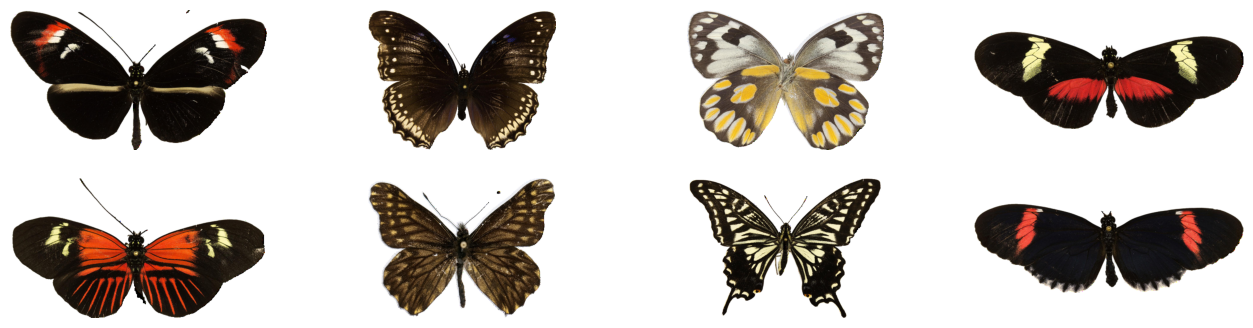

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader


image_size=128
batch_size=16

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:10]["image"]):
    axs[i//4-1][i-(i//4)*4].imshow(image)
    axs[i//4-1][i-(i//4)*4].set_axis_off()
fig.show()


# resize all images to the same size
# the transform function receives a batch of rows from dataset
# in torchvision we can chain transform operations by creating a compose.
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),             # gives us virtually more examples for training
        transforms.ToTensor(),                         # we need a tensor image (ch,w,h) instead of a PIL image (w,h,c)
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(batch):
    # from the batch use column "image" and covert to RGB format
    images = [preprocess(image.convert("RGB")) for image in batch["image"]]
    # return a new dict that only  contains the batch of images
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print (dataset)

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## add noise to an image using a scheduler

torch.Size([1, 3, 128, 128])


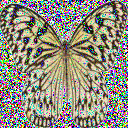

In [ ]:

import torch
from PIL import Image
from diffusers import DDPMScheduler

sample_image = dataset[0]["images"].unsqueeze(0)
print(sample_image.shape)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

display_sample(noisy_image)


The training objective of the model is to predict the noise added to the image

In [ ]:
from torch.nn.functional import mse_loss

noise_residual = model(noisy_image, timesteps).sample
loss = mse_loss(noise_residual, noise)

print (loss)

tensor(1.1014, grad_fn=<MseLossBackward0>)


ok no create an optimizer and a leraning rate scheduler and build a training loop

In [ ]:
!pip install --upgrade  diffusers[training] accelerate transformers datasets safetensors --quiet

from torch.nn.functional import mse_loss
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
from datasets import load_dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from safetensors.torch import save_model


image_size=128
batch_size=16
eval_batch_size = 16  # how many images to sample during evaluation
num_epochs = 50
gradient_accumulation_steps = 1
learning_rate = 1e-4
lr_warmup_steps = 500

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:10]["image"]):
    axs[i//4-1][i-(i//4)*4].imshow(image)
    axs[i//4-1][i-(i//4)*4].set_axis_off()
fig.show()


# resize all images to the same size
# the transform function receives a batch of rows from dataset
# in torchvision we can chain transform operations by creating a compose.
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),             # gives us virtually more examples for training
        transforms.ToTensor(),                         # we need a tensor image (ch,w,h) instead of a PIL image (w,h,c)
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(batch):
    # from the batch use column "image" and covert to RGB format
    images = [preprocess(image.convert("RGB")) for image in batch["image"]]
    # return a new dict that only  contains the batch of images
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * num_epochs),
)


def save_eval_images(epoch, model, noise_scheduler):
    pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=16,
        generator=torch.Generator(device='cpu').manual_seed(1234), # Use a separate torch generator to avoid rewinding the random state of the main training loop
        num_inference_steps =1000
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join("/content/", "sample_data")
    print (f"save images to {test_dir}")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
    save_model(model,f"{test_dir}/model_{epoch:04d}")


model=model.to("cuda")

progress_bar = tqdm(total=len(train_dataloader)*num_epochs)
progress_bar.set_description(f"Epochs {num_epochs} ")

for epoch in range(num_epochs):
        model.train(True)
        for step, batch in enumerate(train_dataloader):
            images = batch["images"].to("cuda")
            batchsize = images.shape[0]
            # create a new noise image with the same size as the training image
            noise = torch.randn(images.shape, device="cuda")
            # create a random list of timesteps for every image in the batch to train the model on
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (batchsize,), device="cuda",
                dtype=torch.int64
            )
            # add noise to all the images
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = mse_loss(noise_pred, noise)
            loss.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(batchsize)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": step, "epoch": epoch}
            progress_bar.set_postfix(**logs)
        model.eval()
        if (epoch+1) % 5 == 0:
            save_eval_images(epoch, model, noise_scheduler)

progress_bar.close()

#

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epochs 50 : : 5000it [06:18, 12.48it/s, epoch=4, loss=0.163, lr=6.3e-5, step=62]  

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 5000it [06:30, 12.48it/s, epoch=4, loss=0.163, lr=6.3e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 10000it [18:52, 12.69it/s, epoch=9, loss=0.0321, lr=9.94e-5, step=62]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 10000it [19:04, 12.69it/s, epoch=9, loss=0.0321, lr=9.94e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 15000it [31:27, 12.67it/s, epoch=14, loss=0.0336, lr=9.32e-5, step=62]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 15000it [31:39, 12.67it/s, epoch=14, loss=0.0336, lr=9.32e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 20000it [44:01, 12.47it/s, epoch=19, loss=0.0176, lr=8.1e-5, step=62] 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 20000it [44:13, 12.47it/s, epoch=19, loss=0.0176, lr=8.1e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 25000it [56:34, 12.61it/s, epoch=24, loss=0.0422, lr=6.46e-5, step=62]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 25000it [56:46, 12.61it/s, epoch=24, loss=0.0422, lr=6.46e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 30000it [1:09:06, 12.69it/s, epoch=29, loss=0.0398, lr=4.62e-5, step=62]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 30000it [1:09:18, 12.69it/s, epoch=29, loss=0.0398, lr=4.62e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 35000it [1:21:40, 12.76it/s, epoch=34, loss=0.0512, lr=2.82e-5, step=62]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 35000it [1:21:53, 12.76it/s, epoch=34, loss=0.0512, lr=2.82e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 40000it [1:34:13, 12.61it/s, epoch=39, loss=0.0296, lr=1.33e-5, step=62]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs 50 : : 40000it [1:34:33, 12.61it/s, epoch=39, loss=0.0296, lr=1.33e-5, step=62]

save images to /content/sample_data


Epochs 50 : : 40064it [1:40:35,  2.59s/it, epoch=40, loss=0.0225, lr=1.31e-5, step=3]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')